# Repository Hotspots

We are going to see find out which files are changed the most. For this we are using a dataset created from JUnit4 with JQAssistant and the following Cypher query:

```MATCH
   (commit:Git:Commit),
   (commit)-[:CONTAINS_CHANGE]->(change:Git:Change),
   (author:Git:Author)-[:COMMITTED]->(commit),
   (change)-[]->(file:File),
   (class)-[:HAS_SOURCE]->(file:Git:File),
   (package:Package)-[:CONTAINS]->(class)
RETURN DISTINCT
   commit.sha AS sha,
   commit.date AS date,
   commit.time AS time,
   commit.author AS author,
   author.email AS author_email,
   author.identString AS author_id,
   commit.committer AS commiter,
   commit.message AS message,
   change.modificationKind AS modificationKind,
   file.fileName AS file,
   class.name AS class,
   package.fileName AS package```

With this we have the commits history for all the files.

# Setting Up

In [1]:
import pandas as pd
import calendar

history = pd.read_json("../datasets/git_history_junit4.gz", encoding='utf-8-sig')

# Exploring Data

In [2]:
history.head()

,sha,date,time,author,author_email,author_id,commiter,message,modificationKind,file,fileType,class,package
0,3a5c6b4d08f408c8ca6a8e0bae71a9bc5a8f97e8,2020-08-02,20:24:18 +0200,Rahul Nagekar <rahul.nagekar1@gmail.com>,rahul.nagekar1@gmail.com,Rahul Nagekar <rahul.nagekar1@gmail.com>,GitHub <noreply@github.com>,Deprecated since jdk9 replacing constructor in...,M,src/main/java/junit/framework/Assert.java,java,Assert,/junit/framework
1,44cd8f80dbac11849a42a5d73fc9b5ddc75cd1b4,2016-12-01,21:35:45 +0100,Kevin Cooney <kcooney@google.com>,kcooney@users.noreply.github.com,Kevin Cooney <kcooney@users.noreply.github.com>,Stefan Birkner <github@stefan-birkner.de>,Change generics on ExpectedException.expectCau...,M,src/main/java/org/junit/internal/matchers/Thro...,java,ThrowableCauseMatcher,/org/junit/internal/matchers
2,44cd8f80dbac11849a42a5d73fc9b5ddc75cd1b4,2016-12-01,21:35:45 +0100,Kevin Cooney <kcooney@google.com>,kcooney@users.noreply.github.com,Kevin Cooney <kcooney@users.noreply.github.com>,Stefan Birkner <github@stefan-birkner.de>,Change generics on ExpectedException.expectCau...,M,src/main/java/org/junit/rules/ExpectedExceptio...,java,ExpectedException,/org/junit/rules
3,44cd8f80dbac11849a42a5d73fc9b5ddc75cd1b4,2016-12-01,21:35:45 +0100,Kevin Cooney <kcooney@google.com>,kcooney@users.noreply.github.com,Kevin Cooney <kcooney@users.noreply.github.com>,Stefan Birkner <github@stefan-birkner.de>,Change generics on ExpectedException.expectCau...,M,src/main/java/org/junit/rules/ExpectedExceptio...,java,ExpectedException$ExpectedExceptionStatement,/org/junit/rules
4,8baae6ecd6e719c8de58bac1a191de2badd78ed3,2016-12-08,19:16:32 +0100,Kevin Cooney <kcooney@google.com>,kcooney@users.noreply.github.com,Kevin Cooney <kcooney@users.noreply.github.com>,Kevin Cooney <kcooney@google.com>,Do not use @Override when implementing methods...,M,src/main/java/org/junit/internal/management/Fa...,java,FakeThreadMXBean,/org/junit/internal/management


## Times Each File was Modified

In [3]:
file_change_count = history[["file", "package"]]

# Clean up
file_change_count = file_change_count.value_counts().reset_index(name="changes")
file_change_count = file_change_count.sort_values("file")
file_change_count = file_change_count.set_index("file")

file_change_count.head()

,package,changes
file,,
src/junit/extensions/ActiveTestSuite.java,/junit/extensions,4
src/junit/extensions/RepeatedTest.java,/junit/extensions,3
src/junit/extensions/TestDecorator.java,/junit/extensions,2
src/junit/extensions/TestSetup.java,/junit/extensions,4
src/junit/framework/Assert.java,/junit/framework,2


### Average Number of Changes

Usually, how many changes does a file receive? And how many changes is too much?

In [4]:
changes_mean = file_change_count["changes"].mean()
changes_mean

54.64965986394558

In [5]:
file_change_count["distance"] = file_change_count.apply(lambda x: x["changes"] / changes_mean, axis=1)
file_change_count.head()

,package,changes,distance
file,,,
src/junit/extensions/ActiveTestSuite.java,/junit/extensions,4,0.073194
src/junit/extensions/RepeatedTest.java,/junit/extensions,3,0.054895
src/junit/extensions/TestDecorator.java,/junit/extensions,2,0.036597
src/junit/extensions/TestSetup.java,/junit/extensions,4,0.073194
src/junit/framework/Assert.java,/junit/framework,2,0.036597


### Top Most Changed Files

In [6]:
top_file_change_count = file_change_count[file_change_count["distance"] >= 15]
top_file_change_count = top_file_change_count.sort_values("changes", ascending=False)
top_file_change_count

,package,changes,distance
file,,,
src/main/java/org/junit/runners/Parameterized.java,/org/junit/runners,1422,26.020290
src/main/java/org/junit/runners/ParentRunner.java,/org/junit/runners,1372,25.105371


### Hotspot diagram

The previous data identifies those files which receive a lot of commits. But it isn't good for a global view. Lets group it by package.

In [21]:
package_change_count = history[["package"]]

# Clean up
package_change_count = package_change_count.value_counts().reset_index(name="changes")
package_change_count = package_change_count.sort_values("package")
package_change_count = package_change_count.set_index("package")

package_change_count.head()

,changes
package,
/junit/extensions,66
/junit/framework,429
/junit/runner,180
/junit/textui,44
/org/junit,860


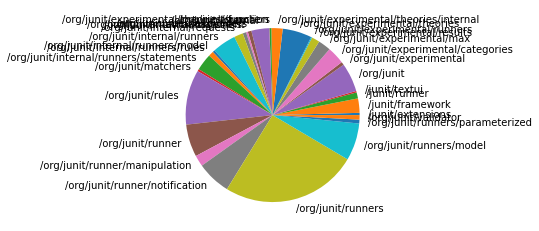

In [22]:
ax = package_change_count.plot.pie(y="changes", legend=False)
ax.axes.get_yaxis().get_label().set_visible(False)